## IO的发展


| 技术阶段             | 特点                                                                 | 优点                                                                 | 缺点                                                                 | 典型应用                                                                 |
|----------------------|----------------------------------------------------------------------|----------------------------------------------------------------------|----------------------------------------------------------------------|--------------------------------------------------------------------------|
| **传统阻塞 IO (BIO)** | 同步阻塞模型，每个连接需要一个线程                                     | 编程模型简单，易于理解                                               | 线程资源消耗大，不适合高并发                                         | Java 的 `InputStream` 和 `OutputStream`                                   |
| **非阻塞 IO (NIO)**   | 同步非阻塞模型，使用多路复用器管理多个连接                             | 支持高并发，资源利用率高                                             | 编程模型复杂，调试困难                                               | Java 的 `Channel`、`Buffer` 和 `Selector`                                 |
| **异步 IO (AIO)**     | 异步非阻塞模型，操作系统完成 IO 操作后通过回调通知应用程序              | 性能高，适合高并发、高吞吐量                                         | 实现复杂，操作系统支持有限                                           | Java 的 `AsynchronousFileChannel`                                         |
| **零拷贝**            | 减少数据在内存中的拷贝次数，数据直接从内核缓冲区传输到磁盘或网络       | 减少了 CPU 和内存开销，显著提高性能                                  | 需要操作系统支持                                                     | Java 的 `FileChannel.transferTo()` 和 `FileChannel.transferFrom()`         |
| **内存映射文件**      | 将文件直接映射到内存中，通过内存地址访问文件数据                       | 访问速度快，适合大文件读写                                           | 需要处理内存映射的复杂性                                             | Java 的 `MappedByteBuffer`                                                |
| **分布式 IO**         | 数据存储和访问分布在多个节点上                                         | 高可用性、高扩展性                                                   | 数据一致性、网络延迟、故障恢复                                       | 分布式文件系统（如 HDFS）、分布式数据库（如 Cassandra）、分布式缓存（如 Redis） |
| **IO 多路复用**       | 通过一个线程管理多个 IO 连接，使用事件驱动模型                         | 支持高并发，资源消耗低                                               | 编程模型复杂，调试困难                                               | `select`、`poll`、`epoll`（Linux），Java 的 `Selector`                     |
| **高性能网络 IO 框架**| 基于 NIO 或 AIO，提供高性能的网络 IO 支持，封装底层细节                | 高性能、高扩展性，提供丰富的功能和工具                               | 需要学习框架的使用                                                   | Netty、Mina（Java），libevent（C/C++）                                    |
| **未来趋势**          | 异步化、零拷贝、分布式、硬件加速、AI 驱动的 IO 优化                    | 更高效、更智能、更适应大规模分布式系统                               | 技术复杂度高，实现难度大                                             | 异步 IO、零拷贝技术、AI 驱动的 IO 优化                                    |

### BIO/NIO

#### BIO 每连接一个线路
#### NIO 非阻塞IO
**非阻塞**   
ss.configureBlocking(false)  
**IO复用**  
while 循环中检查 accept() 和 read()，代码模拟了非阻塞的 I/O 复用模式，即在 JVM 中一个线程内复用 I/O 操作.


```java
LinkedList<SocketChannel> clients = new LinkedList<>();

ServerSocketChannel ss = ServerSocketChannel.open();
ss.bind(new InetSocketAddress(8090));
ss.configureBlocking(false);// 不阻塞

while (true) {
    // 每2秒拉一次客户端请求
    Thread.sleep(1000);
    // 在NIO时代，如果ss.configureBlocking(false)上面这里不会阻塞，有连接返回连接，无连接返回-1
    SocketChannel accept = ss.accept();
    if (accept == null) {
        System.out.println("无客户端连接，accept方法没有阻塞=====");
    } else {
        accept.configureBlocking(false);

        clients.add(accept);
    }

    ByteBuffer bf = ByteBuffer.allocate(4096);

    // 遍历已经链接进来的客户端 读取数据
    for (SocketChannel client : clients) {
        int read = client.read(bf);
        if (read > 0) {
            bf.flip();
            byte[] bytes = new byte[bf.limit()];
            bf.get(bytes);
            String ret = new String(bytes);
            System.out.println(client.socket().getPort() + ":" + ret);
            bf.clear();
        }
    }
}
```




### Select/Poll

**解决痛点**：  
传统NIO在每一次轮询，都需要把所有客户端连接FD一个一个传递给内核，频繁调度内核，涉及用户态到内核态切换，很耗性能。  
**优点**：  
将所有fd 一次传递给内核， 每次轮询只调度内核一次。  
**Select/Poll的区别**  
select受限于操作系统最大可打开fd个数， 一般是1024；而poll使用链表管理fd集合，理论上没有最大fd上限。

```java
Selector selector = Selector.open();
ss.register(selector, SelectionKey.OP_ACCEPT);

while (true) {
  // selector已经注册了客户端和服务端socketchannel, 每次循环，selecor阻塞等待一批 jvm程序准备好的io操作通道，
  // 然后将这些通道发送到linux内核处理io操作，返回ready io
  selector.select(); // 调用内核select,poll或epoll
  // 返回的是一个集合，包含了所有准备好进行 I/O 操作的通道（所有感兴趣的IO事件）
  Set<SelectionKey> selectedKeys = selector.selectedKeys();
  Iterator<SelectionKey> iterator = selectedKeys.iterator();

  while (iterator.hasNext()) {
    SelectionKey key = iterator.next();
    iterator.remove();

    if (key.isAcceptable()) {
      ServerSocketChannel serverSocketChannel = (ServerSocketChannel) key.channel();
      SocketChannel clientChannel = serverSocketChannel.accept();
      clientChannel.configureBlocking(false);
      // 注册客户端连接到 Selector，监听 OP_READ 事件
      clientChannel.register(selector, SelectionKey.OP_READ);
      ...
    }
  }
}
```



### Epoll
**解决痛点**：  
select/poll 改多次调度内核为 批量一次调度， 但没有解决每次都需要遍历fd集合的问题。  
也就是说， 每次轮询，应用程序需要把所有连接的fd传递给内核， 内核又需要遍历所有fd，最后标记出来ready io, 在这一过程中，有大量遍历是不必要。  
**Epoll的改进**：  
在内核维护fd集合，应用进程不需要每次轮询都把所有fd传递给内核。  
内核以红黑树结构存储fd集合，selector.select()调用时，内核以O(logn)的时间复杂度搜索红黑树，标记ready io, 放到事件队列，同时通过事件驱动函数将ready io写到selector.selectedkeys里。   
当客户端连接新注册或注销时，调用epoll_ctl方法，在红黑树上新增或删除节点。  

**Epoll一定比Select/Poll性能好吗**？  
不一定。在秒杀场景中，假定有2亿用户参加活动，每个用户只会与秒杀服务器建立连接并通讯一次，那么内核需要在内核缓冲区维护一个2亿节点的红黑树，而对树的维护只是频繁地增加和删除节点，并没有有效复用；相反， 在这种场景下，如果使用select/poll模型， 每次jvm向内核传递fd集合都会被内核遍历，但这些fd一定有ready io, 不会产生无效遍历。因此在秒杀场景下select/poll模型的性能更好，而聊天室场景下，epoll性能更好。

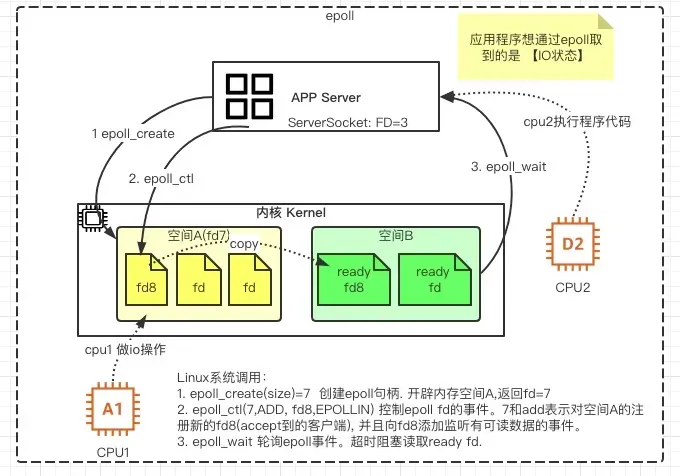



## IO相关常见面试题

#### Java的IO流分几种？
- 字节流 如InputStream, OutputStream
- 字符流 如Reader，Writer
- 缓冲流 如BufferedInputStream
- 转换流 如InputStreamReader OutputStreamWriter


---
#### Java NIO和传统IO的区别
传统IO： InputStream， OutputStream。  
特点：资源消耗大

NIO的核心组件：Channel， Buffer，Selector  
特点：支持阻塞IO和事件驱动。   




## IO性能优化


### 零拷贝
**传统IO**  
内核缓存区 -- 用户缓冲区。    
**零拷贝**  
数据直接从内核缓冲区传输到磁盘或网络，无需经过用户缓冲区。  

实现：
FileChannel.transferTo() 或 FileChannel.transferFrom()

### 使用缓冲流
如 BufferedInputStream、BufferedOutputStream、BufferedReader、BufferedWriter。

### 异步IO
使用 AsynchronousFileChannel 实现异步文件读写。

In [ ]:
AsynchronousFileChannel channel = AsynchronousFileChannel.open(Paths.get("file.txt"));
ByteBuffer buffer = ByteBuffer.allocate(1024);
Future<Integer> result = channel.read(buffer, 0);

while (!result.isDone()) {
    // 可以做其他事情
}

buffer.flip();
System.out.println(new String(buffer.array()));
channel.close();